# 06. Tracking con ML Flow

## Importacion de la data

In [13]:
import pandas as pd
import numpy as np
df_news=pd.read_csv("../Datos/noticias_bitcoin_sentimientos.csv")
df_btc=pd.read_csv("../Datos/BTC_USD_Media_Movil.csv")
df_btc['Date']=pd.to_datetime(df_btc['Date'], format='%Y-%m-%d')
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1096 non-null   datetime64[ns]
 1   Close      1096 non-null   float64       
 2   High       1096 non-null   float64       
 3   Low        1096 non-null   float64       
 4   Open       1096 non-null   float64       
 5   Volume     1096 non-null   float64       
 6   Close_7d   1090 non-null   float64       
 7   Volume_7d  1090 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 68.7 KB


In [14]:
df_news['fecha'] = pd.to_datetime(df_news['fecha'], format='%Y-%m-%d')

df_news_avg_score = df_news.groupby('fecha')['score'].mean().reset_index()

In [15]:
df_model=df_btc[['Date','Close']]
df_model = pd.merge(df_model, df_news_avg_score, how='left', left_on='Date', right_on='fecha')
df_model.fillna(0, inplace=True)
df_model.drop(columns=['fecha'], inplace=True)
df_model['Date'] = pd.to_datetime(df_model['Date'])

C:\Users\Felipe\AppData\Local\Temp\ipykernel_18476\1242759099.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_model.fillna(0, inplace=True)


## XGBoost parametros

In [16]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Felipe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Mlflow

In [17]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Felipe\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


2025/04/12 22:23:44 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_Prediction_Model' does not exist. Creating a new experiment.


MAE: 2423.06
RMSE: 3266.03


C:\Users\Felipe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1028: UserWarning: [22:23:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/04/12 22:24:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBoost_Price_Prediction' already exists. Creating a new version of this model...
Created version '5' of model 'XGBoost_Price_Prediction'.


Modelo guardado en MLflow como 'XGBoost_Price_Prediction'

Servidor MLflow iniciado en: http://localhost:5014
En este servidor puedes ver los experimentos y el modelo registrado
Para detener el servidor, presiona Ctrl+C en la terminal

Deteniendo el servidor MLflow...
Servidor MLflow detenido.


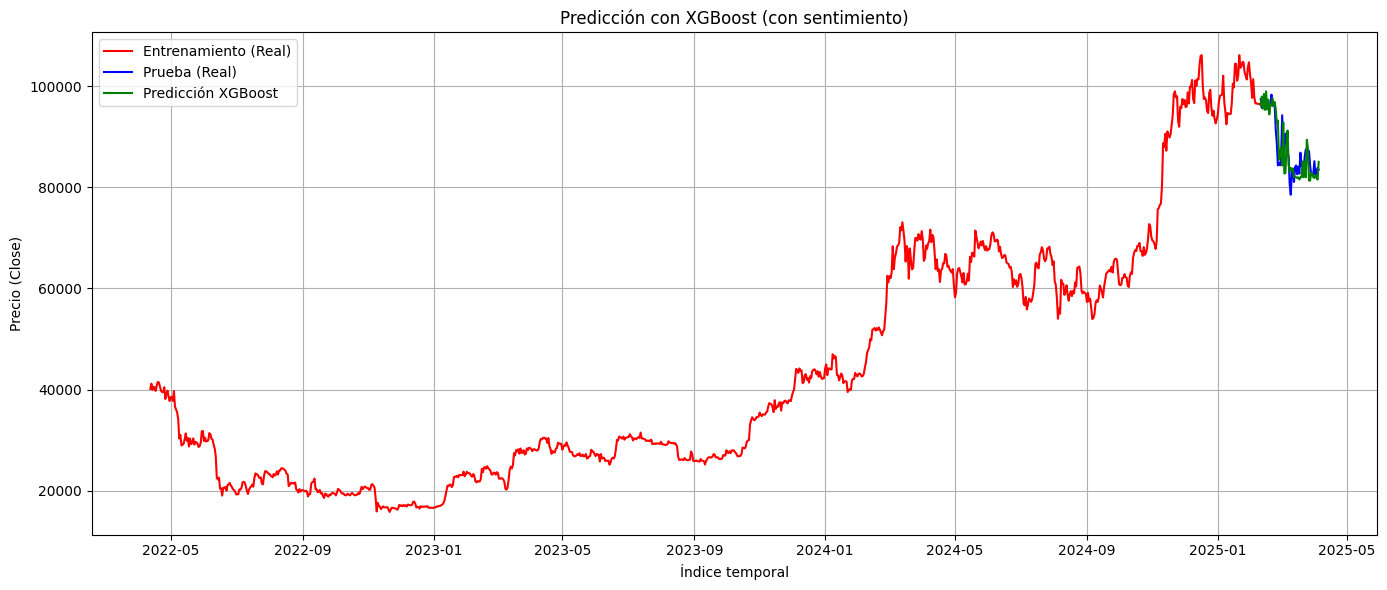

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import mlflow
import mlflow.xgboost
from sklearn.metrics import mean_absolute_error, mean_squared_error
import subprocess
import os
import time
import socket
import cloudpickle
from threading import Thread

# Función para encontrar un puerto disponible
def find_available_port(start_port=5000, max_port=5050):
    for port in range(start_port, max_port):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            if s.connect_ex(('localhost', port)) != 0:
                return port
    return start_port

# Función para iniciar el servidor MLflow en un hilo separado
def start_mlflow_server(port):
    mlflow_process = subprocess.Popen(
        f"mlflow ui --port {port}",
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    return mlflow_process

# 1. Crear variables rezagadas (lags)
def crear_lags(data, target_col, n_lags):
    df = data.copy()
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df.dropna()

# Suponemos que tienes un DataFrame llamado df_model y df_btc
# Si no tienes estos datos disponibles, deberás ajustar el código

# Configura el experimento MLflow
mlflow.set_experiment("XGBoost_Prediction_Model")

# Inicia una corrida de MLflow
with mlflow.start_run(run_name="xgboost_model_with_lags"):
    
    # Prepara los datos
    n_lags = 7
    df_lags = crear_lags(df_model, 'Close', n_lags)
    
    # 2. Separar en conjunto de entrenamiento y prueba (95/5)
    train_size = int(len(df_lags) * 0.95)
    train = df_lags.iloc[:train_size]
    test = df_lags.iloc[train_size:]
    
    X_train = train.drop(columns=['Close', 'Date'])
    y_train = train['Close']
    X_test = test.drop(columns=['Close', 'Date'])
    y_test = test['Close']
    
    # 3. Configurar los hiperparámetros
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 500,
        "learning_rate": 0.05,
        "max_depth": 5,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "gamma": 0.1,
        "min_child_weight": 5,
        "reg_alpha": 0.1,
        "reg_lambda": 1,
        "random_state": 42
    }
    
    # Registrar los hiperparámetros en MLflow
    for param_name, param_value in params.items():
        mlflow.log_param(param_name, param_value)
    
    # Entrenar el modelo XGBoost
    model_sent = xgb.XGBRegressor(**params)
    model_sent.fit(X_train, y_train)
    
    # 4. Predicciones
    y_pred = model_sent.predict(X_test)
    
    # 5. Evaluación
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Registrar métricas en MLflow
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    
    # Generar y guardar gráfica
    plt.figure(figsize=(14, 6))
    
    # Graficar entrenamiento en rojo
    plt.plot(df_btc['Date'][y_train.index], y_train.values, label='Entrenamiento (Real)', color='red')
    
    # Graficar prueba real en azul
    plt.plot(df_btc['Date'][y_test.index], y_test.values, label='Prueba (Real)', color='blue')
    
    # Graficar predicción en verde punteado
    plt.plot(df_btc['Date'][y_test.index], y_pred, label='Predicción XGBoost', color='green')
    
    # Estética
    plt.title('Predicción con XGBoost (con sentimiento)')
    plt.xlabel('Índice temporal')
    plt.ylabel('Precio (Close)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Registrar feature importance
    feature_importance = model_sent.feature_importances_
    feature_names = X_train.columns
    
    # Crear DataFrame de importancia de características
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
     # Guardar modelo con pickle
    with open("../Datos/xgboost_model.pkl", "wb") as f:
        cloudpickle.dump(model_sent, f)
    
    # Registrar el modelo en MLflow
    mlflow.xgboost.log_model(
        model_sent, 
        "xgboost_model",
        registered_model_name="XGBoost_Price_Prediction"
    )
    
    print("Modelo guardado en MLflow como 'XGBoost_Price_Prediction'")

# Después de guardar el modelo, inicia el servidor MLflow
mlflow_port = find_available_port()
mlflow_process = start_mlflow_server(mlflow_port)

print(f"\n===================================================")
print(f"Servidor MLflow iniciado en: http://localhost:{mlflow_port}")
print(f"En este servidor puedes ver los experimentos y el modelo registrado")
print(f"Para detener el servidor, presiona Ctrl+C en la terminal")
print(f"===================================================\n")

# Mantener el script ejecutándose para que el servidor MLflow permanezca activo
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Deteniendo el servidor MLflow...")
    mlflow_process.terminate()
    print("Servidor MLflow detenido.")



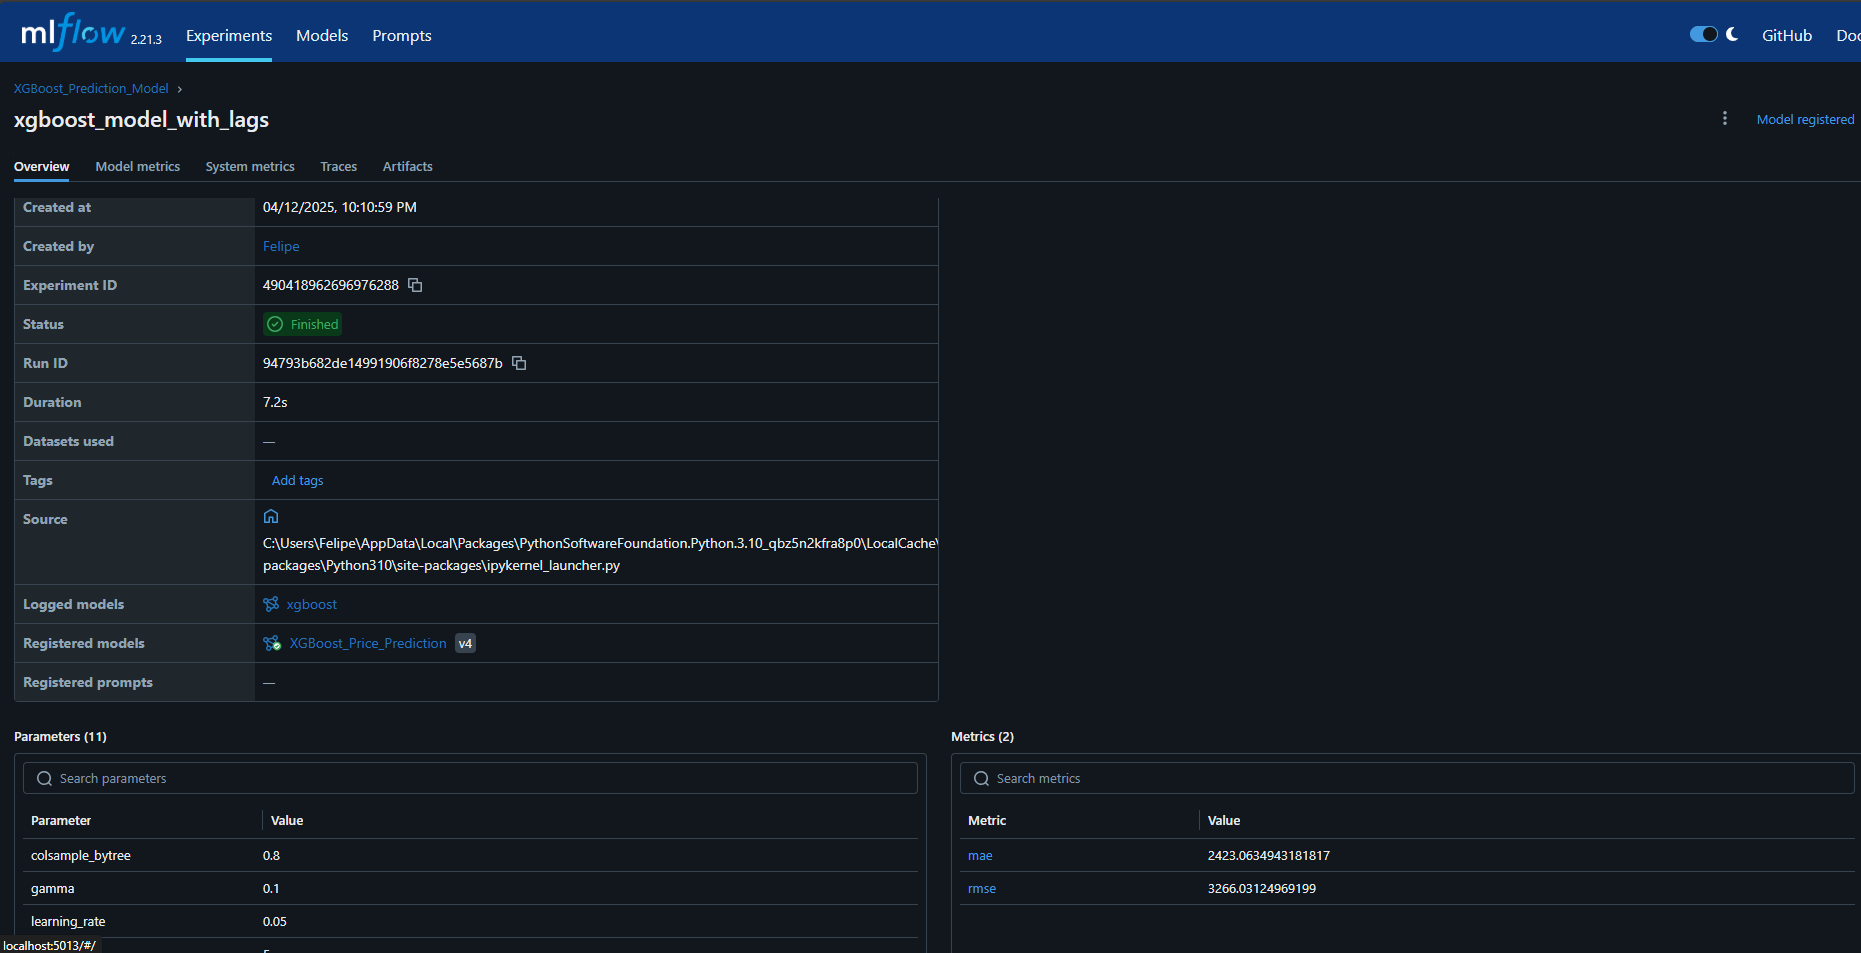